<a href="https://colab.research.google.com/github/yuyang-zhong/EEG-Neural/blob/master/DMA20_Lab_3_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DMA Fall '20

In [1]:
NAME = "Yuyang Zhong"
COLLABORATORS = ""

---

# Lab 3: Decision Trees

**Please read the following instructions very carefully**

## Working on the assignment / FAQs
- **Always use the seed/random_state as *42* wherever applicable** (This is to ensure repeatability in answers, across students and coding environments) 
- Questions can be either autograded and manually graded.
- The type of question and the points they carry are indicated in each question cell
- An autograded question has 3 cells
     - **Question cell** : Read only cell containing the question
     - **Code Cell** : This is where you write the code
     - **Grading cell** : This is where the grading occurs, and **you are required not to edit this cell**
- Manually graded questions only have the question and code cells. **All manually graded questions are explicitly stated**
- To avoid any ambiguity, each question also specifies what *value* must be set. Note that these are dummy values and not the answers
- If an autograded question has multiple answers (due to differences in handling NaNs, zeros etc.), all answers will be considered.
- Most assignments have bonus questions for extra credit, do try them out! 
- You can delete the `raise NotImplementedError()` for all questions.
- **Submitting the assignment** : Download the '.ipynb' file from Colab and upload it to bcourses. Do not delete any outputs from cells before submitting.
- That's about it. Happy coding!


## About the dataset
This assignment uses a dataset obtained from the JSE Data Archive that contains biological and self-reported activity traits of a sample of college students at a single university uploaded in 2013. The study associated with these data focused on exploring if a correspondence exists between eye color and and other traits. You will be using gender as the target/label in this lab.

FEATURE DESCRIPTIONS: 
- Color (Blue, Brown, Green, Hazel, Other)
- Age (in years)
- YearinSchool (First, Second, Third, Fourth, Other)
- Height (in inches)
- Miles (distance from home town of student to Ames, IA) 
- Brothers (number of brothers)
- Sisters (number of sisters)
- CompTime (number of hours spent on computer per week)
- Exercise (whether the student exercises Yes or No)
- ExerTime (number of hours spent exercising per week)
- MusicCDs (number of music CDs student owns)
- PlayGames (number of hours spent playing games per week)
- WatchTV (number of hours spent watching TV per week

https://ww2.amstat.org/publications/jse/jse_data_archive.htm (eyecolorgenderdata.csv)


In [2]:
from collections import Counter, defaultdict
from itertools import combinations 
import pandas as pd
import numpy as np
import operator
import math

!wget -nc http://people.ischool.berkeley.edu/~zp/course_datasets/eye_color.zip
!unzip -u eye_color.zip
!ls
df = pd.read_csv('Eye_Color.csv')
# remove NA's and reset the index
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df = df.reset_index(drop=True)

df.head()

File ‘eye_color.zip’ already there; not retrieving.

Archive:  eye_color.zip
Eye_Color.csv  Eye_Color_Dataset_Description.txt  eye_color.zip  sample_data


,gender,age,year,eyecolor,height,miles,brothers,sisters,computertime,exercise,exercisehours,musiccds,playgames,watchtv
0,female,18,first,hazel,68.0,195.0,0,1,20.0,Yes,3.0,75.0,6.0,18.0
1,male,20,third,brown,70.0,120.0,3,0,24.0,No,0.0,50.0,0.0,3.0
2,female,18,first,green,67.0,200.0,0,1,35.0,Yes,3.0,53.0,8.0,1.0
3,male,23,fourth,hazel,74.0,140.0,1,1,5.0,Yes,25.0,50.0,0.0,7.0
4,female,19,second,blue,62.0,60.0,0,1,5.0,Yes,4.0,30.0,2.0,5.0


---
**Question 1 (0.5 points, autograded)**: How many males and females exist in the dataset?

In [3]:
#The value set in the variables must be integers
gender_counts = df.gender.value_counts()
num_males = gender_counts['male']
num_females = gender_counts['female']

In [4]:
#This is an autograded cell, do not edit
print(num_males, num_females)

910 1078


---
**Question 2 (0.5 points, autograded)**: What is the Gini Index of this dataset, using males and females as the target classes?

In [5]:
# YOUR CODE HERE
def gini(df):
  """
  Calculates the gini index from a series of value counts.
  """
  series = df.gender.value_counts()
  total = sum(series)
  percentage_series = series / total

  return 1-sum(percentage_series**2)

In [6]:
#The value set in the variable must be float
gini_index = gini(df)

In [7]:
#This is an autograded cell, do not edit
print(gini_index)

0.4964292799047807


---
## Best Split of a numeric feature
**Question 3 (1.5 points, autograded)**: What is the best split point of the 'height' feature? (Still using males and females as the target classes, assuming a binary split)

Recall that, to calculate the best split of this numeric field, you'll need to order your data by 'height', then consider the midpoint between each pair of consecutive heights as a potential split point, then calculate the Gini Index for that partitioning. You'll want to keep track of the best split point and its Gini Index (remember that you are trying to minimize the Gini Index). 

There are a lot of ways to do this. Some are very fast, others very slow. One tip to make this run quickly is, as you consecutively step through the data and calculate the Gini Index of each possible split point, keep a running total of the number of rows for each candidate that are located above and below the split point. 

Some Python tips: 

* Counter(), from the collections module, is a special dictionary for counting values of a key
* zip() lets you concatenate lists into a list of tuples (for example, if we have a list of the candidates and a list of transaction amounts, zip(candidate_list, transaction_amount) would give us a list of (candidate, transaction amount) pairs

In [8]:
def gini_a(df):
  true_rows = df[df.split]
  false_rows = df[df.split == False]
  total_num_rows = df.shape[0]
  
  return (true_rows.shape[0] / total_num_rows) * gini(true_rows) + (false_rows.shape[0] / total_num_rows) * gini(false_rows)

In [9]:
df_height = df.sort_values('height')
heights = df_height.height.unique()

best_gini = 1
best_split_point = 0

for i in range(len(heights) - 1):
  split_point = (heights[i]+heights[i+1])/2
  df_height['split'] = df_height.height.apply(lambda x: x < split_point)
  this_gini = gini_a(df_height)
  
  if this_gini < best_gini:
    best_gini = this_gini
    best_split_point = split_point

#The value set in the variable must be float

In [10]:
#This is an autograded cell, do not edit
print(best_split_point)

68.5


---
**Question 4 (0.5 points, autograded)**: What is the Gini index of the best split point of the 'height' feature? (Still using males and females as the target classes, assuming a binary split)


In [11]:
#The value set in the variable must be float
gini_of_best_split_point = best_gini

In [12]:
#This is an autograded cell, do not edit
print(gini_of_best_split_point)

0.2655288120702919


---
**Question 5 (0.5 points, autograded)**: How much does this partitioning reduce the Gini Index over the Gini index of the overall dataset?

In [13]:
#The value set in the variable must be float
gini_difference = gini_index - gini_of_best_split_point

In [14]:
#This is an autograded cell, do not edit
print(gini_difference)

0.2309004678344888


---
**Question 6 (0.5 points, autograded)**: How many 'female' and 'male' rows are shorter than the best height split point?

In [15]:
#The value set in the variable must be integer
df_height['split'] = df_height.height.apply(lambda x: x < best_split_point)
short_counts = df_height[df_height.split].gender.value_counts()

female_rows_below = short_counts['female']
male_rows_below = short_counts['male']

In [16]:
#This is an autograded cell, do not edit
print(female_rows_below, male_rows_below)

905 142


---
**Question 7 (0.5 points, autograded)**: How many 'female' and 'male' rows are taller than the best height split point?

In [17]:
tall_counts = df_height[df_height.split == False].gender.value_counts()

female_rows_above = tall_counts['female']
male_rows_above = tall_counts['male']

In [18]:
#This is an autograded cell, do not edit
print(female_rows_above, male_rows_above)

173 768


---
## Best Split of a Categorial Variable

**Question 8 (0.5 points, autograded)**: How many possible splits are there of the eyecolor feature? (Assuming binary split)

Python tip: the combinations function of the itertools module allows you to enumerate combinations of a list. You might want to Google 'power set'.


In [19]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

split_list = list(powerset(df.eyecolor.unique()))

In [20]:
#The value set in the variable must be integer
num_of_splits = len(split_list) / 2

In [21]:
#This is an autograded cell, do not edit
print(num_of_splits)

15.0


---
**Question 9 (1 points, autograded)**: Which split of eyecolor best splits the female and male rows, as measured by the Gini Index?

In [22]:
# YOUR CODE HERE
df_color = df.sort_values('eyecolor')
best_gini = 1
best_split_list = None

for i in range(len(split_list)):
  df_color['split'] = df_color.eyecolor.apply(lambda x: x in list(split_list[i]))
  this_gini = gini_a(df_color)
  
  if this_gini < best_gini:
    best_gini = this_gini
    best_split_list = split_list[i]

#The value set in the variable must be float

In [23]:
#The value set in the variable must be an array
colour_group_1 = np.array(best_split_list)
colour_group_2 = np.array([c for c in df.eyecolor.unique() if c not in best_split_list])

In [24]:
#This is an autograded cell, do not edit
print(colour_group_1, colour_group_2)

['green'] ['hazel' 'brown' 'blue' 'other']


---
**Question 10 (0.5 points, autograded)**: What is the Gini Index of this best split?

In [25]:
#The value set in the variable must be float
gini_of_best_split_group = best_gini

In [26]:
#This is an autograded cell, do not edit
print(gini_of_best_split_group)

0.4930915729509777


---
**Question 11 (0.5 points, autograded)**: How much does this partitioning reduce the Gini Index over the Gini index of the overall dataset?

In [27]:
#The value set in the variable must be float
gini_difference_2 = gini_index - gini_of_best_split_group

In [28]:
#This is an autograded cell, do not edit
print(gini_difference_2)

0.003337706953802977


---
**Question 12 (1 points, autograded)** : How many 'female' rows and 'male' rows are in your first partition? How many 'female' rows and 'male' rows are in your second partition?

In [29]:
df_color['split'] = df_color.eyecolor.apply(lambda x: x in best_split_list)
p1_counts = df_color[df_color.split].gender.value_counts()
p2_counts = df_color[df_color.split == False].gender.value_counts()

female_rows_below = p1_counts['female']
male_rows_below = p2_counts['male']

In [30]:
#The value set in the variable must be integer, order doesn't matter
partition1_male = p1_counts['male']
partition1_female = p1_counts['female']
partition2_male = p2_counts['male']
partition2_female = p2_counts['female']

In [31]:
#This is an autograded cell, do not edit
print(partition1_male, partition1_female, partition2_male, partition2_female)

107 190 803 888


---
## Training a decision tree
**Question 13 (1 points, autograded)**: Using all of the features in the original dataframe read in at the top of this notebook, train a decision tree classifier that has a depth of three (not including the root node). What is the accuracy of this classifier on the training data?

Scikit-learn classifiers require class labels and features to be in numeric arrays. As such, you will need to turn your categorical features into numeric arrays using DictVectorizer. This is a helpful notebook for understanding how to do this: http://nbviewer.ipython.org/gist/sarguido/7423289. You can turn a pandas dataframe of features into a dictionary of the form needed by DictVectorizer by using df.to_dict('records'). Make sure you remove the class label first (in this case, gender). If you use the class label as a feature, your classifier will have a training accuracy of 100%! The example notebook link also shows how to turn your class labels into a numeric array using sklearn.preprocessing.LabelEncoder().

In [32]:
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing

X = df.drop('gender', axis=1).to_dict('records')
y = df['gender']

vec = DictVectorizer()
X = vec.fit_transform(X)

le = preprocessing.LabelEncoder()
le.fit(["male", "female"])
y = le.transform(y)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)

#The value set in the variable must be float
accuracy = clf.score(X_test, y_test)

In [35]:
#This is an autograded cell, do not edit
print(accuracy)

0.8551307847082495


---
**Question 14 (1 points, manually graded)**: Using the following code snippet, export your decision tree to graphviz and visualize it. In your write-up, write down the interpretation of the rule at each node which is used to perform the splitting.

In order to install graphviz, you may need to download the tool from [this website](https://graphviz.gitlab.io), and then pip3/conda install the python libraries you do not have.

Mac users can use ```brew install graphviz``` instead of following the link, and linux users can do the same using their favourite package manager (for example, Ubuntu users can use ```sudo apt-get install graphviz```, followed by the necessary pip3/conda installations.

In [36]:
!sudo apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


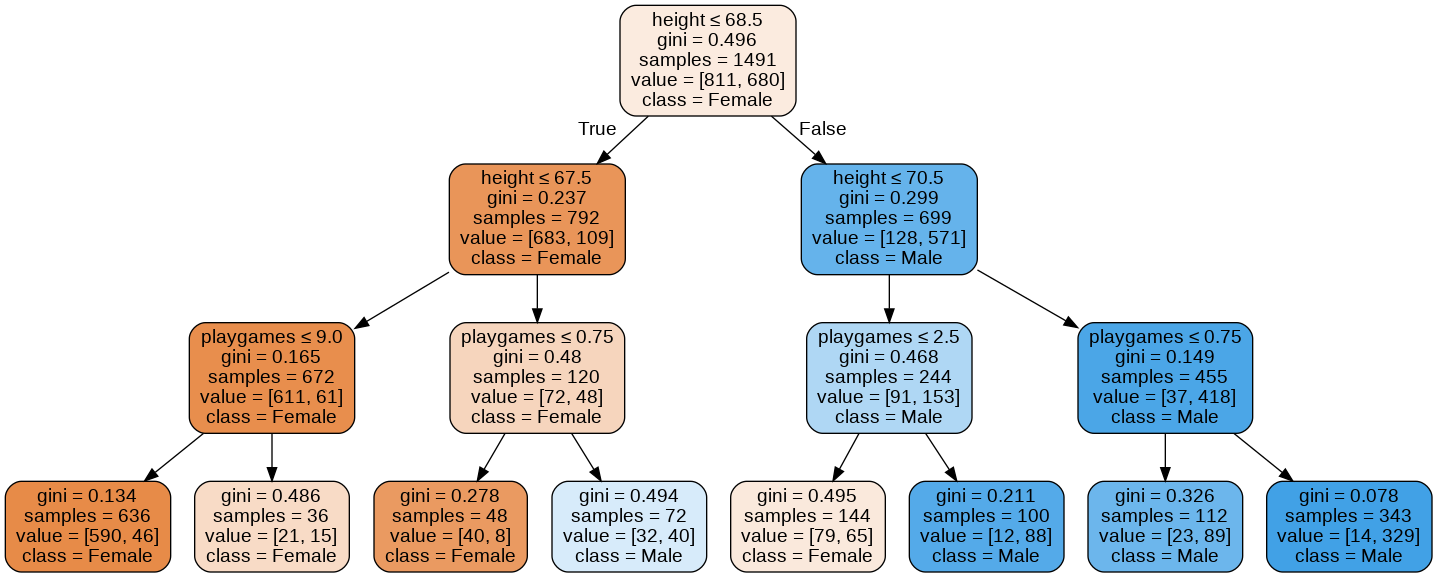

In [37]:
from IPython.display import Image  
import pydotplus 
import pydot
from sklearn.externals.six import StringIO
from sklearn import tree

# clf = your classifier
dotfile = StringIO() 
tree.export_graphviz(clf, out_file=dotfile,
                     feature_names=vec.feature_names_,  
                         class_names=['Female', 'Male'],  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dotfile.getvalue())
Image(graph.create_png())

#Ignore the cell below, but do not delete it. It is used to grade the image output of this cell.

In [38]:
# YOUR CODE HERE
# the split rules are as follows:
# height at 68.5
# height at 67.5 and 70.5
# playgames at 7.5, 0.75, 2.5, 0.75

---
## Bonus Question (2 points, auto graded)
For each of your leaf nodes, specify the percentage of 'female' rows in that node (out of the total number of rows at that node)


In [39]:
#The value set in the variable must be array
ratios = [679/781, 601/659, 575/617, 26/42, 78/122, 34/71, 135/710, 93/251, 80/146, 13/105, 42/459, 26/112, 16/347] #Replace 0 with the actual value


In [40]:
#This is an autograded cell, do not edit
print(ratios)

[0.8693982074263764, 0.9119878603945372, 0.9319286871961102, 0.6190476190476191, 0.639344262295082, 0.4788732394366197, 0.19014084507042253, 0.3705179282868526, 0.547945205479452, 0.12380952380952381, 0.0915032679738562, 0.23214285714285715, 0.04610951008645533]
